In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

## Бутстрап
Бутстрап позволяет многократно извлекать подвыборки из выборки, полученной в рамках экспериментва

В полученных подвыборках считаются статистики (среднее, медиана и т.п.)

Из статистик можно получить ее распределение и взять доверительный интервал

ЦПТ, например, не позволяет строить доверительные интервал для медианы, а бутстрэп это может сделать

In [3]:
df = pd.read_csv('/home/jupyter-d.shahvorostov-14/Statistic/lesson9_bootstrap/hw_bootstrap.csv', sep=";", decimal=",")

In [4]:
df = df.drop(columns='Unnamed: 0')

In [5]:
df

,value,experimentVariant
0,10.380495,Control
1,9.546867,Control
2,11.088215,Control
3,10.147274,Control
4,9.789808,Control
...,...,...
995,1000.000000,Treatment
996,1200.000000,Treatment
997,1500.000000,Treatment
998,2000.000000,Treatment


In [6]:
df.dtypes

value                float64
experimentVariant     object
dtype: object

In [7]:
df_Control=df.query('experimentVariant=="Control"').value

In [8]:
df_Control

0      10.380495
1       9.546867
2      11.088215
3      10.147274
4       9.789808
         ...    
495    10.973929
496    10.261074
497     8.780090
498    11.169078
499    11.499566
Name: value, Length: 500, dtype: float64

In [9]:
df_Treatment=df.query('experimentVariant=="Treatment"').value

In [10]:
df_Treatment

500      10.380495
501       9.546867
502      11.088215
503      10.147274
504       9.789808
          ...     
995    1000.000000
996    1200.000000
997    1500.000000
998    2000.000000
999    3000.000000
Name: value, Length: 500, dtype: float64

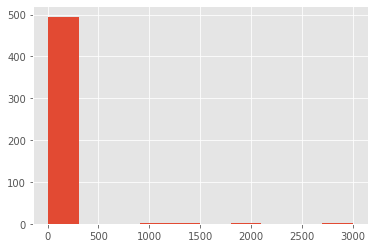

In [21]:
df_Treatment.hist()

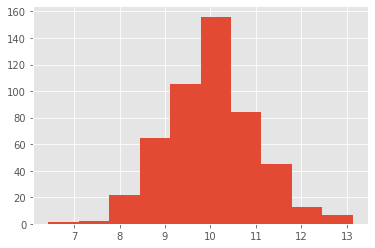

In [23]:
df_Control.hist()

С помощью критерия Манна-Уитни проверим нулевую гипотезу, что распределения в двух группах равны

In [14]:
mannwhitneyu(df_Control, df_Treatment)

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

U-критерий Манна-Уитни не дает нам отклонить нулевую гипотезу.

Применим бутстрап с оценкой среднего, проверим нулевую гипотезу о равенстве средних

In [15]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

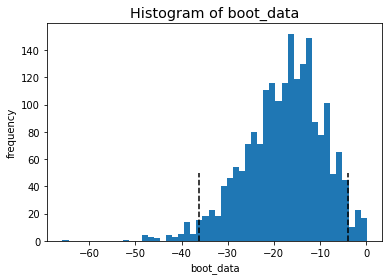

In [16]:
booted_data = get_bootstrap(df_Control, df_Treatment, boot_it = 2000)

Применив бутстрап с оценкой среднего, мы могли бы отклонить нулевую гипотезу о равенстве средних и сделать вывод, что тестовая и контрольная выборка имеют различия.

In [17]:
booted_data["p_value"]

0.03552951743099701

In [18]:
booted_data["ci"]

,0
0.025,-36.127176
0.975,-3.833583


Применим бутстрап с оценкой медиан, проверим нулевую гипотезу о равенстве медианных значений

In [19]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap1(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

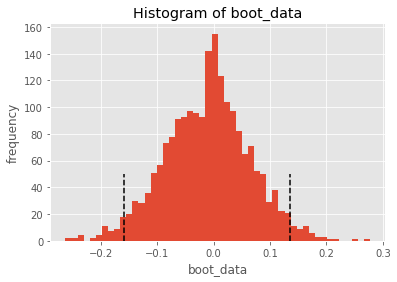

In [20]:
booted_data = get_bootstrap1(df_Control, df_Treatment, boot_it = 2000)

 Как видно из графика, 0 попал в доверительный интервал. Бутстрап, но уже по медиане не дает нам отклонить нулевую гипотезу, так как p-value сильно больше 0.05

In [97]:
booted_data["p_value"]

0.8809355044137852

In [98]:
booted_data["ci"]

,0
0.025,-0.158212
0.975,0.128222


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


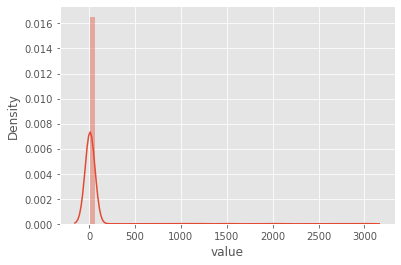

In [95]:
bx= sns.distplot(df_Treatment)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


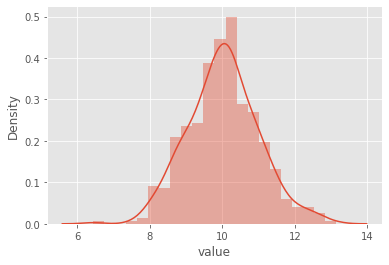

In [96]:
ax= sns.distplot(df_Control)

# Вывод
Наличие выбросов нам сильно искажает среднее значение. Применяя бутстрап с оценкой среднего, мы могли бы отклонить нулевую гипотезу о равенстве средних и сделать вывод, что тестовая и контрольная выборка имеют различия. Однако, тот же бутстрап, но уже по медиане не дает нам отклонить нулевую гипотезу, потому что p-value сильно больше 0.05. U-критерий Манна-Уитни так же не дал бы нам отклонить нулевую гипотезу. Оценки pvalue так же направлены как у бутстрапирования медианы